# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

----
## Exploring the Data
1. `'income'`: target label (whether an individual makes more than, or at most, $50,000 annually)
2. All other columns: features about each individual in the census database.

In [1]:
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Import supplementary visualization code visuals.py
import visuals as vs

%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
Compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

### Option 1:

In [2]:
print 'The number of individuals making more than $50,000 annually:{}'.format(data.income.value_counts()[1])
print 'The number of individuals making at most $50,000 annually:{}'.format(data.income.value_counts()[0])                                                                  
print 'Total Number of records {}'.format(len(data))                                                                              
print 'The percentage of individuals making more than $50,000 annually {}'.format(round(float(data.income.value_counts()[1])/float(len(data))*100,2))

The number of individuals making more than $50,000 annually:11208
The number of individuals making at most $50,000 annually:34014
Total Number of records 45222
The percentage of individuals making more than $50,000 annually 24.78


### Option 2: Get results using list comprehension

In [3]:
n_records = float(data.shape[0])

n_greater_50k = float(len([val for val in data.income if val == '>50K']))

n_at_most_50k = float(len([val for val in data.income if val == '<=50K']))

greater_percent = (n_greater_50k/n_records)*100

print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222.0
Individuals making more than $50,000: 11208.0
Individuals making at most $50,000: 34014.0
Percentage of individuals making more than $50,000: 24.78%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data, i.e. Preprocessing
Before data can be used as input for ML algorithms, it must be cleaned, formatted, and restructured.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

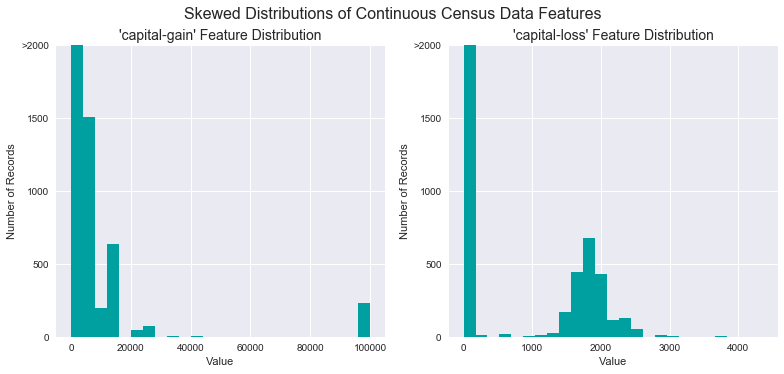

In [4]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a>

So that the very large and very small values do not negatively affect the performance of a learning algorithm. 
Logarithmic transformation: reduces the range of values caused by outliers.

**Important**: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` by **adding +1** to all values.

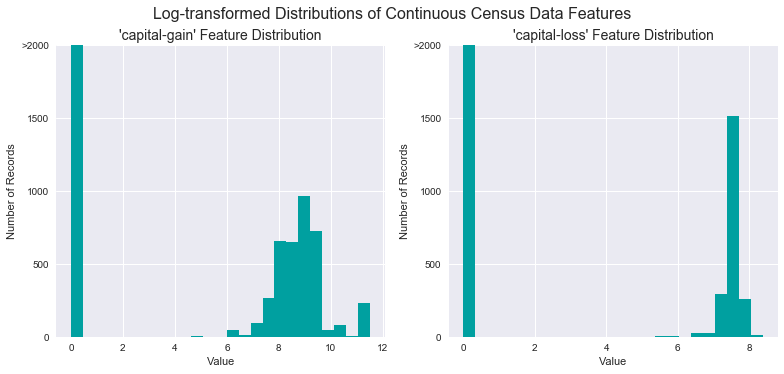

In [5]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features

1. Performing transformations on features that are highly skewed (if needed)
2. Scaling on numerical features. It does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. 
3. Once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

display(features_log_minmax_transform.head(n = 2))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.8,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States


### Implementation: Data Preprocessing --> Non-numeric features

Learning algorithms expect input to be numeric, which requires *categorical variables* to be converted. One option to convert categorical variables is by using the **one-hot encoding** scheme. It creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally,Target labels must be numeric, `'income'`, for ML algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we ca simply implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [7]:
features_log_minmax_transform.head(1)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States


### One Hot encoding using pd.get_dummies
---------------------------

1. Separate Categorical features from continuous features
2. Create dummies' dataframe
3. Merge continuous and dummies frames

In [8]:
# List of categorical variables
dummies = ['workclass','education_level','marital-status','occupation','relationship',
 'race','sex','native-country'] 
# List of numberical features
nondummies = ['age','education-num','capital-gain','capital-loss','hours-per-week'] 

In [9]:
features_final = pd.DataFrame(data = features_log_minmax_transform[nondummies])
features_final_dummies = pd.get_dummies(features_log_minmax_transform[dummies])
features_final[features_final_dummies.columns] = features_final_dummies

In [10]:
features_final.head(n=2)

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,0.301370,0.8,0.667492,0.0,0.397959,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.452055,0.8,0.000000,0.0,0.122449,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


### Encoding Labels using Label encoder 
-----------------------------

Label encoder assigns a number to each category of a variable.

The drawback for ML algos would consider `"more similar"` categories with adjacent numbers (i.e. 3 and 4 vs 1 and 4). 

Since Income has only 2 categories, It is not a problem.

In [11]:
from sklearn.preprocessing import LabelEncoder

In [12]:
encoder = LabelEncoder()

income = pd.DataFrame(data = encoder.fit_transform(income_raw), columns =['Income'])

encoded = list(features_final.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

print encoded

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data
----------------------------------------------

After Preprocessing Data let us create the train and test sets

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)
# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor<a id="cell"></a>
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Question 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

** Please note ** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

** HINT: ** 

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [14]:
TP = float(np.sum(income)) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
#encoded to numerical values done in the data preprocessing step.
FP = float(len(income) - TP) # Specific to the naive case

TN = 0.0 # No predicted negatives in the naive case
FN = 0.0 # No predicted negatives in the naive case

print TP
print FP
print len(income)

11208.0
34014.0
45222


In [15]:
accuracy = TP / len(income)
recall = TP / (TP+FN)
precision = TP / (TP + FP)

beta = 0.5
fscore = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
print "beta:{:.2}, accuracy:{:.4}, recall:{:.2}, precision:{:.4}, fscore:{:.4}"\
.format(beta, accuracy,recall,precision,fscore)

beta:0.5, accuracy:0.2478, recall:1.0, precision:0.2478, fscore:0.2917


In [16]:
print "Naive Predictor: [Accuracy score: {:.4}, F-score: {:.4}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

-----
### Building domain knowledge

Before we continue let us look at the data to see what features could have a higher relative importance.

The function calculates the value_counts for each feature applied to the full dataset (i.e.45,222 datapoints),

as well as only the cases where the income is more than $ 50,000 (i.e. 11,208 datapoints)

Underlying methodology assumption:

Features where the distribution of values between full dataset and >$50K dataset are similar,

They would have low impact to help to separate donors by income.

The reader is invited to either:

1. Print completo & criterio lists to observe the difference in the value counts
2. Select an specific feature and plot it using the **describing** function 

Example of the describing function applied to 'workclass' features is provided below

In [17]:
def describing(cat1, cat2, label1 ="All",label2 =">50K"):
    plt.figure()
    ind = np.arange(len(cat1))  # the x locations for the groups
    width = 0.35       # the width of the bars
    
    fig, ax = plt.subplots(figsize=(16,8))

    rects1 = ax.bar(ind, cat1, width, color='r')

    rects2 = ax.bar(ind + width, cat2, width, color='y')

    # add some text for labels, title and axes ticks
    ax.set_ylabel('% of Total')
    ax.set_title('Difference between full sample and >50K')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(cat1.index)

    ax.legend((rects1[0], rects2[0]), (label1, label2))


    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,'{:.4}'.format(height),ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    plt.show();

In [18]:
def comparacion(tabla, columna, criterio):
    completa = {}
    criteria = {}
    figs = {}
    datos = tabla[tabla[columna] == criterio]
    datos = datos.drop(columna, axis=1)
    titulos = datos[dummies]
    for tit in titulos:
        completa[tit] = (tabla[tit].value_counts().astype(float))/len(tabla[tit])
        criteria[tit] = (datos[tit].value_counts().astype(float))/len(datos[tit])
        #figs[tit] = describing(completa[tit],criteria[tit])
    return completa, criteria

In [19]:
completo, criterio = comparacion(tabla = data, columna= 'income',criterio= '>50K')

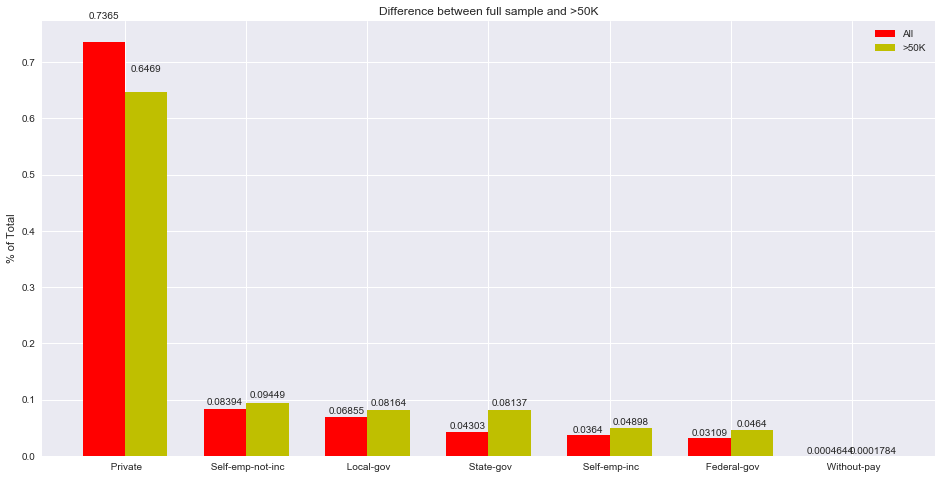

In [20]:
describing(completo['workclass'],criterio['workclass'])

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

** HINT: **

Structure your answer in the same format as above^, with 4 parts for each of the three models you pick. Please include references with your answer.

**Answer: **

#### What type of problem is the one que are trying to solve?

1. Classification
2. Predicting values
3. Discovering Structures
4. Finding unusual data points

We are trying to classify if a person makes more than 50K a year or not. 

Which makes our problem a **Classification** problem.

Let us check which algorithms we should use for **Classification**

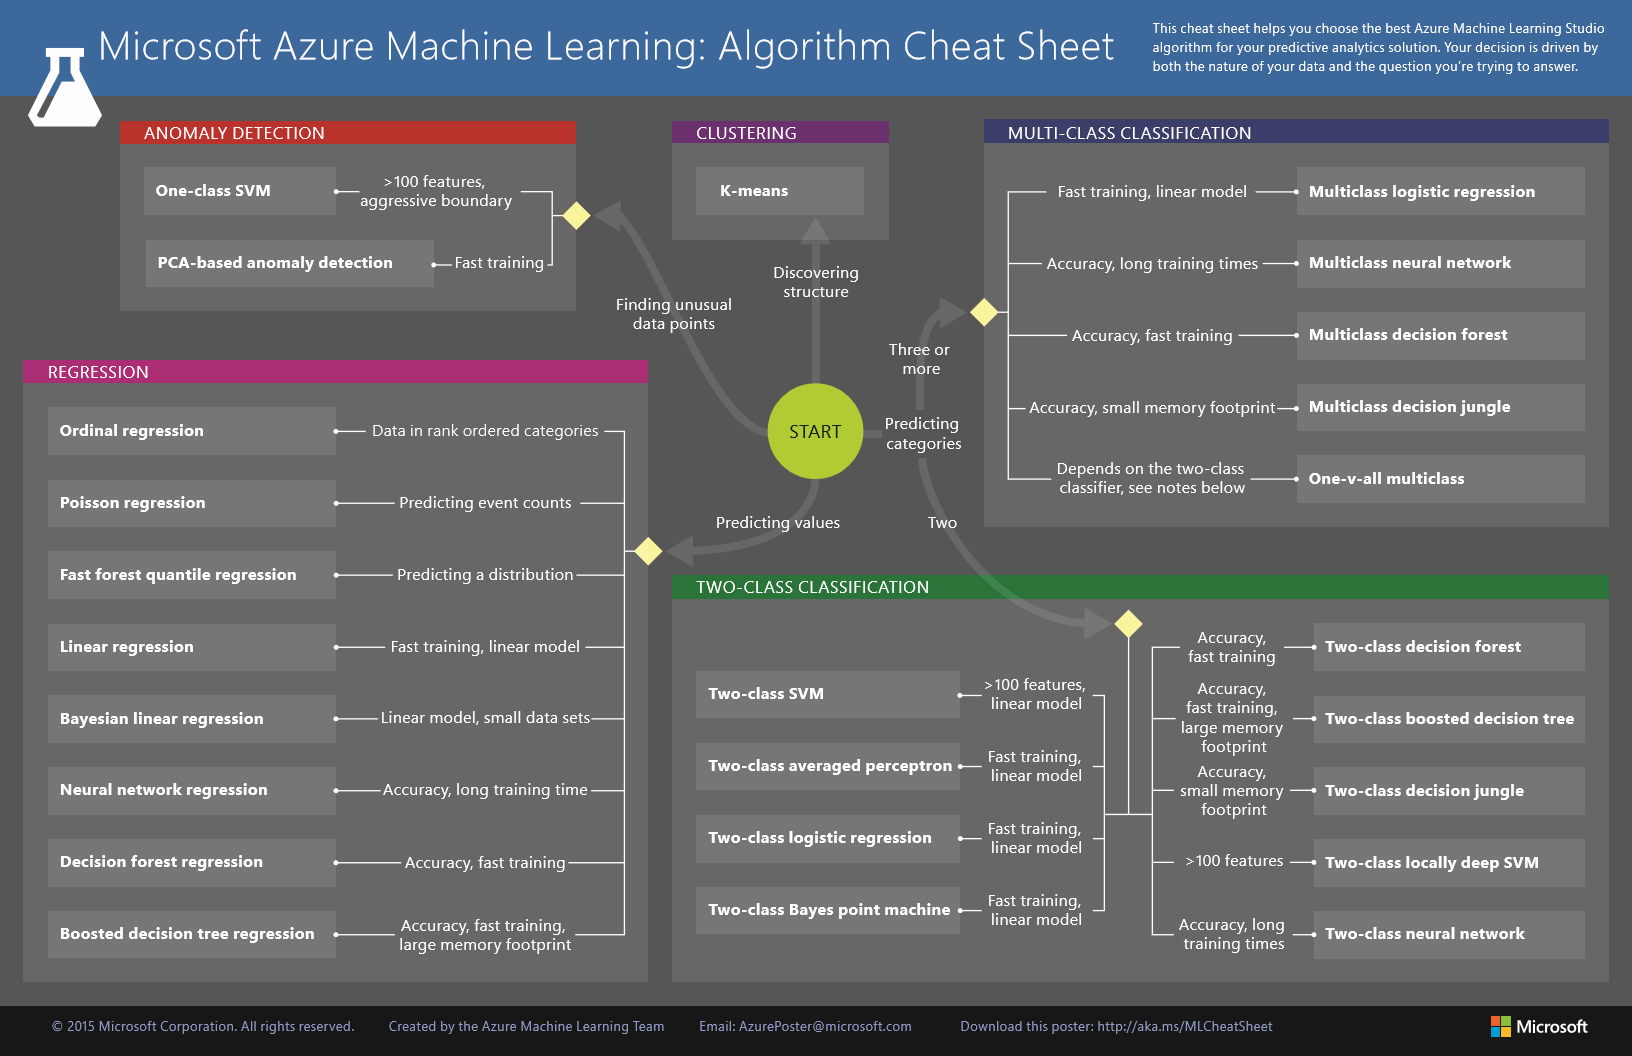

In [21]:
from IPython.display import Image
Image('1.jpg')

### Selecting Algoritms:

The methodology to select the algorithms will be based on **highest performance before calibration approach**:

1. Create a list of target algorithms
2. Run brute force exercise testing all of them
3. Use "off the shelf" hyperparameters
4. Compute time and score for each of them
5. Select the best 3 algorithms

In [22]:
from sklearn.neural_network import MLPClassifier 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier 
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import VotingClassifier

names = ["Nearest Neighbors", "Linear SVM",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes","Logistic Regression","Voting"]
classifiers = [
    KNeighborsClassifier(),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    MLPClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    LogisticRegression(),
    VotingClassifier(estimators=[("Nearest Neighbors",KNeighborsClassifier()),
                                 ("Linear SVM",SVC()),
                                 ("Decision Tree",DecisionTreeClassifier()),
                                 ("Random Forest",RandomForestClassifier()),
                                 ("Neural Net",MLPClassifier()),
                                 ("AdaBoost",AdaBoostClassifier()),
                                 ("Naive Bayes",GaussianNB()),
                                 ("Logistic Regression",LogisticRegression())])]

# iterate over classifiers

for name, clf in zip(names, classifiers):
    clf.fit(X_train, np.ravel(y_train)) # np.ravel converts panda column to numpy array format
    %time score = clf.score(X_test, np.ravel(y_test))
    print "Classifier: {}, score: {:.4}".format(name, score)

Wall time: 1min 11s
Classifier: Nearest Neighbors, score: 0.8235
Wall time: 36.7 s
Classifier: Linear SVM, score: 0.8371
Wall time: 27 ms
Classifier: Decision Tree, score: 0.8166
Wall time: 114 ms
Classifier: Random Forest, score: 0.8389
Wall time: 93 ms
Classifier: Neural Net, score: 0.8499
Wall time: 412 ms
Classifier: AdaBoost, score: 0.8576
Wall time: 86 ms
Classifier: Naive Bayes, score: 0.5977
Wall time: 18 ms
Classifier: Logistic Regression, score: 0.8419
Wall time: 2min 36s
Classifier: Voting, score: 0.8542


### The winners are:

<ul>
<li>Classifier: AdaBoost --> score: 0.8576, Wall time: 90 ms</li>
<li>Classifier: Neural Net --> score: 0.8474, Wall time: 28 ms</li>
<li>Classifier: Logistic Regression --> score: 0.8419,Wall time: 8 ms</li>
</ul>

----
#### Algo 1 : AdaBoost
- Describe one real-world application in industry where the model can be applied.
    1. Face detection
    2. Pedestrian detection
    3. Multi class text categorization


- Model Strengths; when does it perform well?
    1. Tends to perform better than any individual component
    2. Impervious to overfitting
    3. Can achieve similar classification results than other methods with less tweaking of parameters and settings


- Model Weaknesses; when does it perform poorly?
    1. Can be sensitive to noise and data outliers.

- What makes this model a good candidate for the problem, given what you know about the data?

The classifier delivered the best performance before hyperparameters calibration.

[Source](https://fenix.tecnico.ulisboa.pt/downloadFile/3779579716974/Boosting%20-%20Ferreira%20and%20Figueiredo%202013.pdf)

[Source 1](http://www.nickgillian.com/wiki/pmwiki.php/GRT/AdaBoost)

----
#### Algo 2 : Neural Net
- Describe one real-world application in industry where the model can be applied.
    1. Character recognition
    2. Image compression


- Model Strengths; when does it perform well?
    1. Ability to learn non-linear models
    2. Ability to learn models in real-time

- Model Weaknesses; when does it perform poorly?
    1. Hidden layers might have non-convex loss functions where more than one local minimun might exist.
    2. It requires tunning of the hyperparameters
    3. Sensitive to feature scaling

- What makes this model a good candidate for the problem, given what you know about the data?

The classifier provides a high score and suitability to the specific case.

[Source](http://scikit-learn.org/stable/modules/neural_networks_supervised.html)



----
#### Algo 3 : Logistic Regression
- Describe one real-world application in industry where the model can be applied.
    1. Image segmentation
    2. Geographic Image Processing
    3. Handwriting recognition

- Model Strengths; when does it perform well?
    1. Low variance
    2. Provides probabilities for outcomes
    3. Works well with diagonal (feature) decision boundaries

- Model Weaknesses; when does it perform poorly?
    1. High bias

- What makes this model a good candidate for the problem, given what you know about the data?

The classifier has a high score. I could have picked other classifiers, however I preferred Logistic regression, so to have 3 algorithms with different calculation methodologies.

[Source](https://www.quora.com/What-are-applications-of-linear-and-logistic-regression)

[Source 1](https://github.com/ctufts/Cheat_Sheets/wiki/Classification-Model-Pros-and-Cons)

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

### Customizations:

The initial template was modified in order to calculate several aspect in one go.

The desire outcome remains the same

Beta = 0.5 by default

In [23]:
from sklearn.metrics import accuracy_score, fbeta_score
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
classifiers = [MLPClassifier(random_state=42),
               AdaBoostClassifier(random_state=42),
               LogisticRegression(random_state=42)]

def train_predict(X_train, y_train, X_test, y_test, beta =0.5): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    bracket = [0.01,0.1,1]
    sample_size = []
    for brack in bracket:
        size = int(len(X_train) * brack)
        sample_size.append(size)
    
      
    results = {}
    
    classifiers = [MLPClassifier(),AdaBoostClassifier(),LogisticRegression()]
    names = ["Neural Net", "AdaBoost","Logistic Regression"]
    # iterate over classifiers
    for sample in sample_size:
        for name, learner in zip(names, classifiers):
            start = time() # Get start time
            learner.fit(X_train[:sample], np.ravel(y_train[:sample]))
            end = time() # Get end time

            results[sample,name,'train_time'] = end - start

            start1 = time() # Get start time
            predictions_test = learner.predict(X_test)
            predictions_train = learner.predict(X_train[:sample])
            end1 = time() # Get end time

            results[sample,name,'pred_time'] = end1 - start1

            results[sample,name,'acc_train'] = accuracy_score(y_train[:sample], predictions_train)

            results[sample,name,'acc_test'] = accuracy_score(y_test, predictions_test)

            results[sample,name,'f_train'] = fbeta_score(y_train[:sample], predictions_train,beta=beta)

            results[sample,name,'f_test'] = fbeta_score(y_test, predictions_test,beta=beta)

    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

In [24]:
train_predict(X_train,y_train,X_test,y_test)

C:\ProgramData\Anaconda3\envs\finding_donors\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


LogisticRegression trained on [361, 3617, 36177] samples.


{(361, 'AdaBoost', 'acc_test'): 0.82067440574903261,
 (361, 'AdaBoost', 'acc_train'): 0.90027700831024926,
 (361, 'AdaBoost', 'f_test'): 0.63275676732141106,
 (361, 'AdaBoost', 'f_train'): 0.81043956043956045,
 (361, 'AdaBoost', 'pred_time'): 0.34200000762939453,
 (361, 'AdaBoost', 'train_time'): 0.6169998645782471,
 (361, 'Logistic Regression', 'acc_test'): 0.81868435599778888,
 (361, 'Logistic Regression', 'acc_train'): 0.86980609418282551,
 (361, 'Logistic Regression', 'f_test'): 0.62886019090398648,
 (361, 'Logistic Regression', 'f_train'): 0.7532051282051283,
 (361, 'Logistic Regression', 'pred_time'): 0.019999980926513672,
 (361, 'Logistic Regression', 'train_time'): 0.007999897003173828,
 (361, 'Neural Net', 'acc_test'): 0.81393034825870647,
 (361, 'Neural Net', 'acc_train'): 0.93074792243767313,
 (361, 'Neural Net', 'f_test'): 0.61750538075228045,
 (361, 'Neural Net', 'f_train'): 0.88888888888888884,
 (361, 'Neural Net', 'pred_time'): 0.07200002670288086,
 (361, 'Neural Net', '

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model

* Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 

** HINT: ** 
Look at the graph at the bottom left from the cell above(the visualization created by `vs.evaluate(results, accuracy, fscore)`) and check the F score for the testing set when 100% of the training set is used. Which model has the highest score? Your answer should include discussion of the:
* metrics - F score on the testing when 100% of the training data is used, 
* prediction/training time
* the algorithm's suitability for the data.

**Answer: **

### Algorithm Screening process:

We have followed a systematic approach were initially took a large set of algorithms and evaluated their raw score. 

The 1<sup>st</sup> step allowed us to select the top 3 candidates.

A 2<sup>nd</sup> step was conducted were the **accuracy score** (<a href= "#cell">[Definition]</a>)and **F-score** (<a href= "#cell">[Definition]</a>) were calculated for each of top candidates using different training sample sizes. Processing time was also considered and calculated as part of the screening process

A table with the relevant summary results is provided below. 

Results on the test set are provided and used as a criteria to select the best algorithm.(For each training sample size, it has been highlithed the best result for each criteria: accuracy, f-score and prediction time)

### Best Classifier: AdaBoost

The results indicate a superior performance when it comes to accuracy and F score by Adaboost.

Logistic regression is by far faster, however its predicting power not as good as AdaBoost.

The high AdaBoost scores before going into tunning its hyperparameters provides extra assurance of further improvements upon hyperparameters calibration.

If time processing becomes a constrain Logistic regression could be use to replace AdaBoost.

Below are the results for the 3 algorithms:

<ul>1% Sample size:
<li><b>(361, 'AdaBoost', 'acc_test'): 0.82067440574903261</b></li>
<li><b>(361, 'AdaBoost', 'f_test'): 0.63275676732141106</b></li>
<li>(361, 'AdaBoost', 'pred_time'): 0.08599996566772461</li>
<li>(361, 'Logistic Regression', 'acc_test'): 0.81868435599778888</li>
<li>(361, 'Logistic Regression', 'f_test'): 0.62886019090398648</li>
<li><b>(361, 'Logistic Regression', 'pred_time'): 0.005000114440917969</b></li>
<li>(361, 'Neural Net', 'acc_test'): 0.80972913211719177</li>
<li>(361, 'Neural Net', 'f_test'): 0.60761195573482263</li>
<li>(361, 'Neural Net', 'pred_time'): 0.01900005340576172</li>
</ul>
<ul>10% Sample size:
<li><b>(3617, 'AdaBoost', 'acc_test'): 0.84986180210060802</b></li>
<li><b>(3617, 'AdaBoost', 'f_test'): 0.7018820838099199</b></li>
<li>(3617, 'AdaBoost', 'pred_time'): 0.1119999885559082</li>
<li>(3617, 'Logistic Regression', 'acc_test'): 0.8385848535102266,</li>
<li>(3617, 'Logistic Regression', 'f_test'): 0.67750677506775059,</li>
<li><b>(3617, 'Logistic Regression', 'pred_time'): 0.00800013542175293</b></li>
<li>(3617, 'Neural Net', 'acc_test'): 0.83493642896627973,</li>
<li>(3617, 'Neural Net', 'f_test'): 0.66338714299360013,</li>
<li>(3617, 'Neural Net', 'pred_time'): 0.026999950408935547</li>
</ul>
<ul>100% Sample size
<li><b>(36177, 'AdaBoost', 'acc_test'): 0.85760088446655613</b></li>
<li><b>(36177, 'AdaBoost', 'f_test'): 0.72455089820359275</b></li>
<li>(36177, 'AdaBoost', 'pred_time'): 0.39299988746643066</li>
<li>(36177, 'Logistic Regression', 'acc_test'): 0.841901603095633,</li>
<li>(36177, 'Logistic Regression', 'f_test'): 0.68316522824165538,</li>
<li><b>(36177, 'Logistic Regression', 'pred_time'): 0.026999950408935547</b></li>
<li>(36177, 'Neural Net', 'acc_test'): 0.84654505251520173,</li>
<li>(36177, 'Neural Net', 'f_test'): 0.68912267155679963,</li>
<li>(36177, 'Neural Net', 'pred_time'): 0.09400010108947754</li>
</ul>

### Question 4 - Describing the Model in Layman's Terms

* In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.

** HINT: **

When explaining your model, if using external resources please include all citations.

**Answer: ** 

AdaBoost is part of ensemble methods.

Ensemble methods relies on the **wisdom of the crowd** premise by assuming that if you ask a complex question to thousand random people, the aggregate answer in many cases will be better than an expert's answer.

Let me provide an analogy of how the classifier works.

Suppose you have a slightly bias coin that has a 51% chance of coming up heads, and 49% chance of coming up tails. If you toss it 1,000 times, you will generally get more or less 510 heads and 490 tails, hence the majority of heads. If you do the math, you will find taht the probability of obtaining a majority of heads after 1,000 tosses i close to 75%. The more you toss the coin, the higher the probability(e.g., with 10,000 tosses, the probability climbs over 97%). This is due to the **law of the large numbers**, as you keep tossing the coin, the ratios of heads gets closer and closer to the probability of heads(51%).

In [25]:
from __future__ import division
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

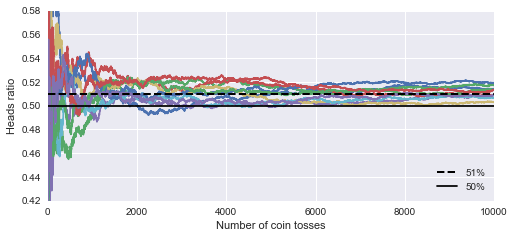

In [26]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.show()

<cite>Source: Hands-on Machine Learning with Scikit-Learn & TensorFlow, Aurelien Geron, O'Reilly</cite> 

AdaBoost relies on combining simple classifiers which are not that great in isolation, however when combined they can actually deliver very good results.

The trick consist in rather than to try to learn from a single strong learner to rather put together many weak learners. In practice it is easier to train several simple classifiers than to develop and train an extremely complex one.

**Let us look at the general concept**

----------------------------

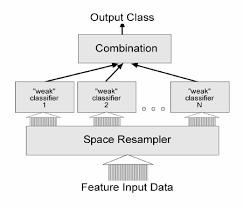

In [27]:
from IPython.display import Image
Image('Adaboost.png',width = 400, height=400)

AdaBoost starts with one classifier/predictor which is trained and used to make predictions on the training set. It will be followed by a new predictor. One way for the new predictor to correct its predecessor is to pay a bit more attention to the training instances that the predecessor underfitted. This results in new predictors focusing more and more on the hard cases.

**Let us look now at the specific AdaBoost model**

------------------------

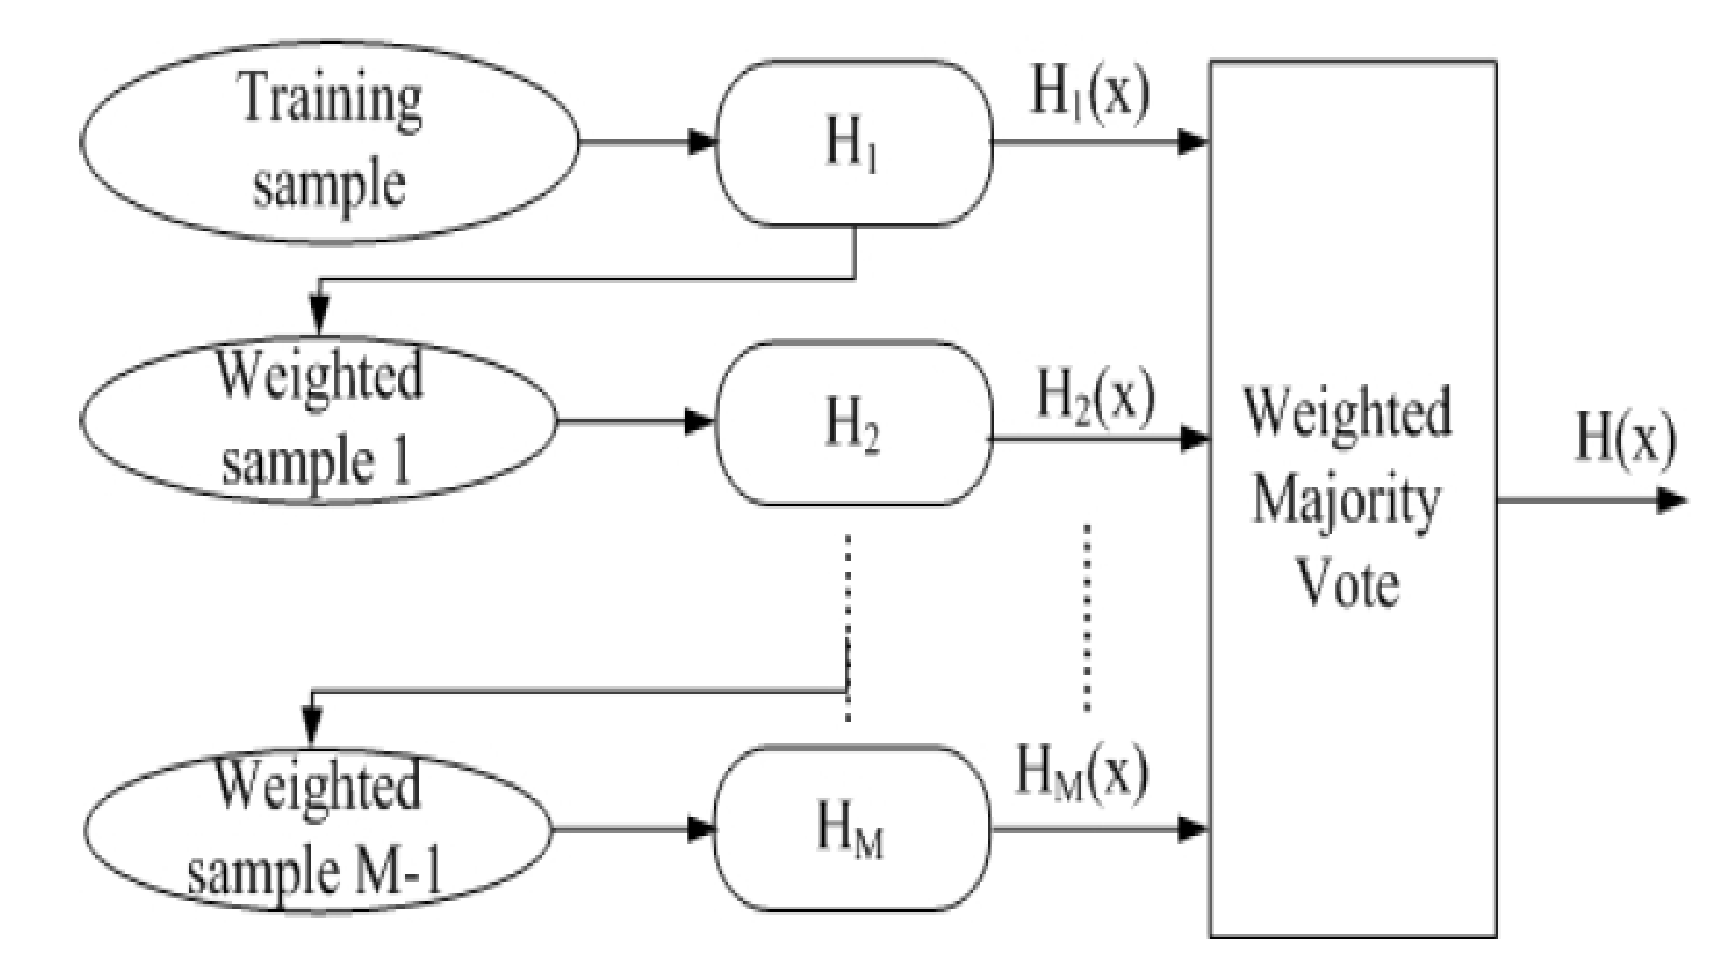

In [28]:
from IPython.display import Image
Image('Adaboost1.png',width = 600, height=600)

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [29]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries

# TODO: Initialize the classifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(random_state=42)

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters =[{'n_estimators':[50,100,200,400,800],'learning_rate':[0.1,0.5,1.0],'algorithm':['SAMME','SAMME.R']}]

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf,parameters,cv=5,scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train,np.ravel(y_train))

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, np.ravel(y_train))).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
Final accuracy score on the testing data: 0.8669
Final F-score on the testing data: 0.7442


### Question 5 - Final Model Evaluation

* What is your optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  

**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |      0.8576       |    0.8669       |
| F-score        |      0.7246       |    0.7442       |

**Answer: **

There is a dramatic jump in accuracy and F-score from the initial Naive model to the optimized AdaBoost model, where accuracy increased **from 0.2478 to 0.8669** while f-score jumped **from 0.2917 to 0.7442**.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

**Answer:**

1. **age**: Tipically people tend to make more money the older they are since they have had more time to develop in their proffessional career.
2. **education-num**: The more years of study it would indicate a higher level of studies which would relate a higher paid jobs/salary. 
3. **occupation**: Occupation are a clear driver for income.
4. **hours-per-week** : the more hours per week an individual work, ceteris paribus, the higher the income of the individual.
5. **workclass**:Normally different sectors tend to pay different salary levels, separating the level income of the people on each sector. 

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

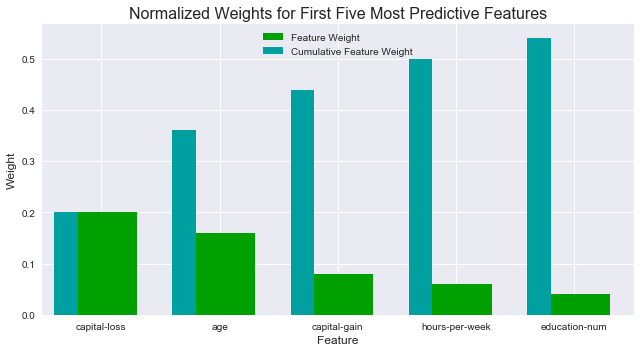

In [30]:
# TODO: Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(random_state=42)

# TODO: Train the supervised model on the training set using .fit(X_train, y_train)
model = clf.fit(X_train,np.ravel(y_train))

# TODO: Extract the feature importances using . 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
* How do these five features compare to the five features you discussed in **Question 6**?
* If you were close to the same answer, how does this visualization confirm your thoughts? 
* If you were not close, why do you think these features are more relevant?

**Answer:**
Questions 1:
Features in common:

1. age 
2. education-num
3. hours-per-week

New Features: 
 
1. Capital-loss
2. Capital-gain

Answer: I did not initially realize the link between not typical events such as capital losses or gains and recurring income.

Question 2: 

The visualization validated 3 of my features and help me to realize the importance of 2 features I understimated


### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [31]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, np.ravel(y_train))

# Make new predictions
%time reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Wall time: 1.08 s
Final Model trained on full data
------
Accuracy on testing data: 0.8669
F-score on testing data: 0.7442

Final Model trained on reduced data
------
Accuracy on testing data: 0.8432
F-score on testing data: 0.7059


### Question 8 - Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would you consider using the reduced data as your training set?

**Answer:**

Question 1:
The Accuracy on full testing data is 0.8669 vs Accuracy on reduced testing data: 0.8432

The F-score on full testing data: 0.7442 vs F-score on reduced testing data: 0.7059

Question 2:

Altough there is a significant improvement in the processing time by using the reduced training set, at least given the initial dataset, the processing time does not seem to be long enough to justify the use the reduced training set.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.